In [ ]:
!pip install --quiet optuna

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import optuna
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets
from keras import backend as K

In [ ]:
#Get access to google drive directory
#Example path "/content/drive/My Drive/Data"
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Train Datasets

#dataset_train_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TRAIN/MSFT_train.csv')
#dataset_train_1 = pd.read_csv('/content/gdrive/MyDrive/stockprice-master/NSE-TATAGLOBAL.csv')
#dataset_train_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TRAIN/AAPL_train.csv')
dataset_train_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TRAIN/DIS_train.csv')
training_set = dataset_train_1.iloc[:, 1:2].values
dataset_train_1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,9.207333,9.515615,9.207333,9.495063,6.968283,6983477
1,1990-01-03,9.495063,9.577271,9.464234,9.515615,6.983367,8077040
2,1990-01-04,9.515615,9.608099,9.412854,9.505339,6.975823,7721845
3,1990-01-05,9.505339,9.597823,9.495063,9.536167,6.998448,3961885
4,1990-01-08,9.536167,9.680031,9.525891,9.608099,7.058542,6647745


In [ ]:
#Process Training Dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
#Process Training Dataset
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#Testing Datasets

#dataset_test_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TEST/MSFT_test.csv')
#dataset_test_1 = pd.read_csv('/content/gdrive/MyDrive/stockprice-master/tatatest.csv')
#dataset_test_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TEST/AAPL_test.csv')
dataset_test_1 = pd.read_csv('/content/gdrive/MyDrive/PYTHON/TEST/DIS_test.csv')
real_stock_price = dataset_test_1.iloc[:, 1:2].values
dataset_test_1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,94.910004,95.279999,92.849998,93.750000,87.376266,5865400
1,2015-01-05,93.279999,93.349998,91.779999,92.379997,86.099403,7789400
2,2015-01-06,92.570000,93.190002,91.160004,91.889999,85.642708,6793100
3,2015-01-07,92.720001,93.150002,92.099998,92.830002,86.518814,6589500
4,2015-01-08,93.870003,94.300003,93.559998,93.790001,87.413536,7579400


In [ ]:
#Autoencoder Model
def AE_model(trial):
  # input layer
  input_layer = Input(shape=(X_train.shape[1], 1))

  # encoding architecture
  encoded_layer1 = Conv1D(50, (3), activation='relu', padding='same')(input_layer)
  encoded_layer1 = MaxPool1D( (2), padding='same')(encoded_layer1)
  encoded_layer2 = Conv1D(50, (3), activation='relu', padding='same')(encoded_layer1)
  encoded_layer2 = MaxPool1D( (2), padding='same')(encoded_layer2)
  encoded_layer3 = Conv1D(50, (3), activation='relu', padding='same')(encoded_layer2)
  latent_view    = MaxPool1D( (2), padding='same')(encoded_layer3)
  # decoding architecture
  decoded_layer1 = Conv1D(50, (3), activation='relu', padding='same')(latent_view)
  decoded_layer1 = UpSampling1D((2))(decoded_layer1)
  decoded_layer2 = Conv1D(50, (3), activation='relu', padding='same')(decoded_layer1)
  decoded_layer2 = UpSampling1D((2))(decoded_layer2)
  decoded_layer3 = Conv1D(50, (3), activation='relu')(decoded_layer2)
  decoded_layer3 = UpSampling1D((2))(decoded_layer3)
  output_layer   = Conv1D(1, (3), padding='same')(decoded_layer3)
  output_layer = tf.reshape(output_layer, [-1, 60])
  # compile the model
  model = Model(input_layer, output_layer)
  optimizer = create_optimizer(trial)
  model.compile(loss = 'mean_squared_error',optimizer=optimizer)
  model.summary()
  return model

In [ ]:
#LSTM Model
def reg_model(trial):  
  regressor = Sequential()

  regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50, return_sequences = True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units = 50))
  regressor.add(Dropout(0.2))

  regressor.add(Dense(units = 1))

  optimizer = create_optimizer(trial)
  regressor.compile(loss = 'mean_squared_error',optimizer=optimizer)
  regressor.summary()
  return regressor

In [ ]:
#Optimizer trial for Optuna
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["Adam"]
    #optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        #kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        kwargs["learning_rate"] = .0004399
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [ ]:
#Optuna Objective function
def objective(trial):
  #model = AE_model(trial)
  model = reg_model(trial)
  monitor = "loss"
  callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
        KerasPruningCallback(trial, monitor),
    ]
  history = model.fit(X_train, y_train,
          batch_size=32,
          callbacks=callbacks,
          epochs=15)

  return history.history[monitor][-1]

In [ ]:
#Create Optuna Study
if __name__ == "__main__":
    
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=1)
    
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    

    

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #Plot optimization history
    #optuna.visualization.matplotlib.plot_optimization_history(study)
    #Plot intermediate values
    #optuna.visualization.matplotlib.plot_intermediate_values(study)

[I 2021-08-04 23:52:28,924] A new study created in memory with name: no-name-d45d67cf-f7fd-417c-a4c6-d15213c2b470


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            2

[I 2021-08-04 23:55:16,222] Trial 0 finished with value: 0.00016117309860419482 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.00016117309860419482.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.00016117309860419482
  Params: 
    optimizer: Adam


In [ ]:
#Predict stock price via X_test in model

regressor = reg_model(trial)
#model = AE_model(trial)
dataset_total = pd.concat((dataset_train_1['Open'], dataset_test_1['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test_1) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 1700):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#predicted_stock_price = model.predict(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 50)           

In [ ]:
#AE Only
#predicted_stock_price_1 = np.delete(predicted_stock_price,[range(2,60)], 1)
#predicted_stock_price_1 = np.delete(predicted_stock_price_1,[0], 1)
#print(predicted_stock_price_1)

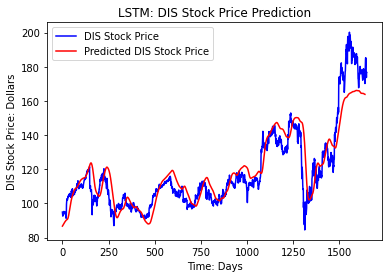

Accuracy:  [0.94529275]


In [ ]:
#Plot Predictions
plt.plot(real_stock_price, color = 'blue', label = 'DIS Stock Price')
plt.plot(predicted_stock_price*-100+570, color = 'red', label = 'Predicted DIS Stock Price')
plt.title('LSTM: DIS Stock Price Prediction')
plt.xlabel('Time: Days')
plt.ylabel('DIS Stock Price: Dollars')
#plt.xlim([0, 200])
plt.legend()
plt.show()
z = 0
for x in range (0,1639,1):
  y1 = real_stock_price[x]
  y2 = (predicted_stock_price[x]*-100+570)
  if y1 > y2:
    z = z +(predicted_stock_price[x]*-100+570)/real_stock_price[x]
  else :
    z = z + real_stock_price[x]/(predicted_stock_price[x]*-100+570)

  
print("Accuracy: ", z/1639)